In [59]:
%load_ext autoreload
%autoreload 2
import sys
import os
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).resolve().parent))

import pandas as pd 
pd.set_option('display.max_columns', 150)

from project.utils.data import *
%aimport project.utils.data
%aimport project.utils.metrics

from sktime.forecasting.all import temporal_train_test_split
import matplotlib.pyplot as plt

In [69]:
df = load_extended_data()

In [3]:
### to do

# choose df columns s. t. feature selection results 

In [70]:
df

,income,outcome,balance,income - outcome,non_working_day,non_working_day_usd,isholiday,key_rate,mosprime_rub_1m,mosprime_rub_1w,mosprime_rub_2m,mosprime_rub_2w,mosprime_rub_3m,mosprime_rub_6m,mosprime_rub_on,usd_xr,usd_xr_mean_7,usd_xr_std_7,usd_xr_min_7,usd_xr_max_7,usd_xr_median_7,day_before_holiday,day_after_holidays,tax,day_before_tax,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,start_of_month,end_of_month,year_2017,year_2018,year_2019,year_2020,year_2021,January,February,March,April,May,June,July,August,September,October,November,December
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-15,0.000000,0.000000,0.000000,0.000000,1,1,0,10.0,10.51,10.40,10.58,10.45,10.59,10.59,10.27,59.3700,59.843643,0.473536,59.3700,60.6569,59.8961,0.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-16,1.082341,1.024345,0.057996,0.057996,0,1,0,10.0,10.47,10.42,10.51,10.44,10.52,10.52,10.32,59.3700,59.659800,0.334609,59.3700,60.1614,59.4978,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-17,0.896334,1.448364,-0.548519,-0.552030,0,0,0,10.0,10.46,10.42,10.49,10.44,10.50,10.50,10.37,59.6067,59.618457,0.318014,59.3700,60.1614,59.4978,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-18,0.754759,0.879560,-0.124801,-0.124801,0,0,0,10.0,10.46,10.42,10.49,10.44,10.50,10.50,10.38,59.4015,59.539629,0.288169,59.3700,60.1614,59.4015,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-19,0.949877,0.955268,-0.005391,-0.005391,0,0,0,10.0,10.46,10.48,10.49,10.48,10.50,10.50,10.43,59.1830,59.399857,0.130436,59.1830,59.6067,59.3700,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,0.000000,1,1,0,4.5,4.90,4.71,5.09,4.76,5.23,5.35,4.68,75.7576,75.190029,0.893932,74.1390,76.1741,75.3585,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,0.000000,0.000000,0.000000,0.000000,1,1,0,4.5,4.90,4.71,5.09,4.76,5.23,5.35,4.68,75.7576,75.421257,0.778663,74.1390,76.1741,75.7576,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,2.356883,3.370738,-1.017679,-1.013855,0,0,0,4.5,4.90,4.69,5.10,4.76,5.28,5.38,4.65,75.7576,75.652486,0.537367,74.6085,76.1741,75.7576,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [60]:
# creating lag features
X = (
    project.utils.data.create_lag_features(df, 'balance', [1, 7, 14])
    .drop(columns=['balance', 'income', 'outcome', 'income - outcome'])
)

# cutting nulls after creating lags 
start = X[X.isnull().sum(axis=1) == 0].index.min()

y, X = df['balance'][start:], X[start:]

assert y.shape[0] == X.shape[0], 'alarm (shape)'
assert y.index.min() == X.index.min(), 'alarm (dates)'

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error

def time_series_model_fit(target,
                          features,
                          params_grid,
                          model_class,
                          cv_window='expanding',
                          n_splits=5,
                          additional_metric=None,
                          test_size=0.2
                         ):
    # Step 1: Split time series data into train and test
    split_index = int(len(target) * (1 - test_size))
    target_train, target_test = target[:split_index], target[split_index:]
    features_train, features_test = features[:split_index], features[split_index:]

    # Step 2: Define Time Series Cross-Validation
    if cv_window == 'expanding':
        cv = TimeSeriesSplit(n_splits=n_splits if n_splits else len(target_train))
    elif cv_window == 'rolling':
        cv = TimeSeriesSplit(n_splits=n_splits)

    # Step 3: Run Grid Search CV on the train data
    grid_search = GridSearchCV(model_class, params_grid, cv=cv, scoring='neg_mean_absolute_error')
    grid_search.fit(features_train, target_train)

    best_model = grid_search.best_estimator_

    # Step 4: Evaluate the model on the test data
    predictions_test = best_model.predict(features_test)
    mae_test = mean_absolute_error(target_test, predictions_test)

    # Step 5: Fit the best model on all data
    best_model.fit(features, target)

    additional_metric_result = None
    if additional_metric:
        additional_metric_result = additional_metric(target_test, predictions_test)

    return best_model, mae_test, additional_metric_result, grid_search.best_params_



In [73]:
from catboost import  CatBoostRegressor

In [114]:
param_grid = {  
    'iterations': [100, 200, 300],  
    'learning_rate': [0.1, 1],  
    'depth': [4, 5, 7, 8],  
    'l2_leaf_reg': [5],  
    # 'random_strength': [1, 5, 10],  
    # 'bagging_temperature': [0.5, 1, 2],  
    # 'random_seed': [0, 42, 123]  
}  
  
model = CatBoostRegressor(verbose=0, loss_function='Huber:delta=0.42') 

In [142]:
# import catboost

In [112]:
from sktime.forecasting.all import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.1)
cbr_rate_train, cbr_rate_test = df.key_rate[y_train.index], df.key_rate[y_test.index]

In [135]:
y_pred = result[0].predict(X_test)

In [136]:
result

(<catboost.core.CatBoostRegressor at 0x1141c8250>,
 0.15117170002689428,
 None,
 {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1})

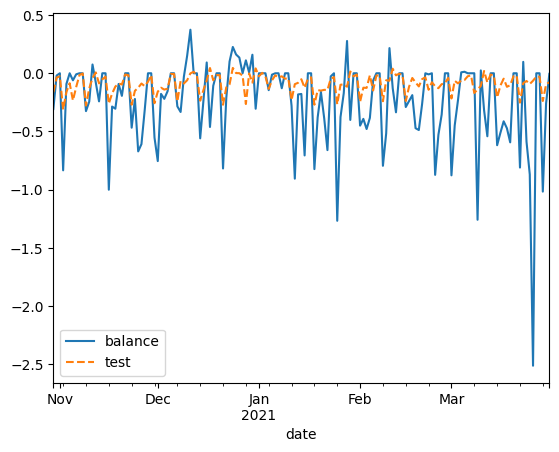

In [137]:
y_test.plot();
plt.plot(y_test.index, y_pred, linestyle='--', label='test');
plt.legend();

In [138]:
mean_absolute_error(y_test, y_pred)

0.21881165808855008

In [29]:
# project.utils.metrics.calculate_add_margin(
#     prediction=1.1,target=1.11,cbr_key_rate=5,
# )

Ну, совсем конечно маленькая маржа

Но нас хотя бы не ударило жестко в минус, я считаю, что это уже успех

In [140]:
project.utils.metrics.calculate_add_margin(
    prediction=1.1,target=1.11,cbr_key_rate=5,
) / df.balance[(df.balance > 0) & (df.index >= y_test.index.min())].mean() * 100

0.03130716192889551

Попробуем погенерить еще фичей, поотбирать посмотрим что получится

## using FS 

In [62]:
from project.pipeline import train_model
from project.utils.data import select_topN_mutual_info, create_target_features
from project.config import DATA_PARAMS

In [63]:
from sktime.forecasting.all import temporal_train_test_split

# creating lag features
target_columns = ['balance', 'income', 'outcome', 'income - outcome']
df = load_extended_data()
features_df = create_target_features(df, target_name="balance")
X = (
    features_df.drop(columns=target_columns)
)

# cutting nulls after creating lags 
start = X[X.isnull().sum(axis=1) == 0].index.min()

y, X = df['balance'][start:], X[start:]

assert y.shape[0] == X.shape[0], 'alarm (shape)'
assert y.index.min() == X.index.min(), 'alarm (dates)'

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)
cbr_rate_train, cbr_rate_test = df.key_rate[y_train.index], df.key_rate[y_test.index]

In [53]:
selected_features = select_topN_mutual_info(
            y = features_df["balance"],
            X=features_df.drop(columns=target_columns),
            N=DATA_PARAMS["max_features"]
        )

In [54]:
len(selected_features)

20

In [68]:
model, selected_features = train_model(
        start_date=y_train.index.min(),
        current_date=y_train.index.max(),
        min_samples_for_training=50,
        use_tsfresh=False,
    )

In [69]:
y_pred = model.predict(X_test[selected_features])

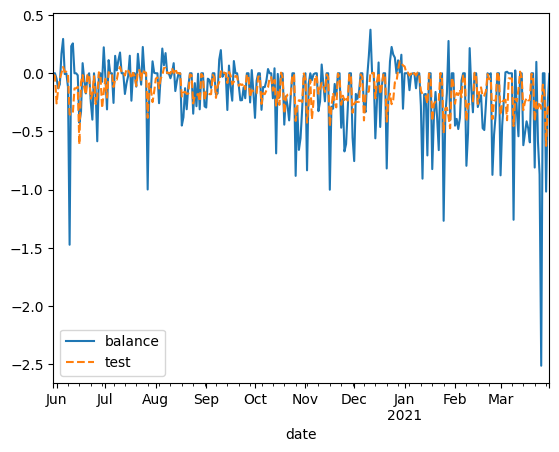

In [70]:
# y_train.plot()
y_test.plot();
plt.plot(y_test.index, y_pred, linestyle='--', label='test');
plt.legend();

In [71]:
project.utils.metrics.calculate_total_add_margin(
    predictions=y_pred, targets=y_test, cbr_key_rates=cbr_rate_test
)

-3.533385319024429e-05